## Horizontal displacement of radiosonds

In [1]:
"""
author: Nora Helgeland
date: May, 2023
"""
#Horizontal_displacement.ipynb>
import numpy as np
import pandas as pd
from datetime import datetime
import time
import csv
import readline
import nc_time_axis
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import os
from netCDF4 import Dataset, num2date, date2num
import math
import sys
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

import gc
gc.collect()

0

Investigating the netcdf file with the atmospheric sounding data from Ås 

In [78]:
filename = "aas_20211231-20220131.nc"
variables_wind =['wind_from_direction','wind_speed', 'longitude', 'latitude', 'time_from_launch', "geopotential_height "]
with Dataset(filename) as ncfile:
    wdir=ncfile[variables_wind[0]][:]
    wspeed=ncfile[variables_wind[1]][:]
    time=ncfile[variables_wind[4]][:]
    longitude=ncfile[variables_wind[2]][:]
    latitude=ncfile[variables_wind[3]][:]
    
    print(latitude)

[[59.66096 -- 59.66109 59.661170000000006 59.66132 59.66149
  59.661660000000005 59.661820000000006 59.661950000000004 59.66208
  59.662180000000006 59.66232 59.6625 59.66272 59.662940000000006 59.6631
  59.663270000000004 59.663500000000006 59.663720000000005
  59.663880000000006 59.664080000000006 59.664320000000004
  59.664530000000006 59.66471 59.664910000000006 59.665090000000006
  59.66527 59.665490000000005 59.665690000000005 59.66588
  59.666070000000005 59.666270000000004 59.66653 59.6668 59.66702 59.6672
  59.667370000000005 59.66761 59.66778 59.66799 59.66823
  59.668440000000004 59.66863 59.668890000000005 59.669160000000005
  59.6694 59.669650000000004 59.66993 59.670190000000005
  59.670390000000005 59.731730000000006 59.731750000000005 59.73176
  59.73176 59.73178 59.731840000000005 59.731910000000006
  59.731950000000005 59.731950000000005 59.73192 59.73189
  59.731880000000004 59.731910000000006 59.731950000000005 59.73196
  59.73192 59.73187 59.73181 59.73176 59.73172

Import dataset for wind in x and y direction

In [22]:
#The wind variable is divided into x and y direction and is 4 dimensional 
#We retrieve the wind speed in x, y direction at height 0 and time 0

df = pd.DataFrame()
df["x"] = wspeed[0]
df["y"]=wdir[0]

df_y = pd.DataFrame(time)
df_y.style.set_caption("wind in y direction")
df


,x,y
0,2.900000,186.0
1,NaN,NaN
2,4.200000,186.0
3,4.800000,186.0
4,5.500000,186.0
...,...,...
2521,62.099998,273.0
2522,62.200001,273.0
2523,62.400002,273.0
2524,62.500000,273.0


### Horizontal displacement

In [11]:
filename = "aas_20211231-20220131.nc"

#### Equations for finding horizontal displacement

$x_k = x_{k-1} + (t_k - t_{k-1})\frac{(u_k - u_{k-1})}{2}$

$y_k = y_{k-1} + (t_k - t_{k-1})\frac{(v_k - v_{k-1})}{2}$

To find the x and y position at layer k we add the change in time multiplied by the average wind speed to the x and y position in the previous layer k-1. We assume a constant vertical displacement rate of 5 m/s. 

In [85]:
def find_horizontal_disp(filename, lat, long):
    #filename2
    """
    Innput
    ------------------------------------------------------------------------
    filename is the name of the dataset containing information of a radiosonde
    (has to be a .txt file). 
    lat and long is the initial longitiude. 
    and latitude of the radiosonde.
    ------------------------------------------------------------------------
    Output
    ------------------------------------------------------------------------
    A new dataframe with the latitudes and longitudes corresponding to the time and vertical 
    displacment
    """
    
  
    variables_wind =['wind_from_direction','wind_speed', 'longitude', 'latitude', 'time_from_launch', "geopotential_height "]
    with Dataset(filename) as ncfile:
        wdir=ncfile[variables_wind[0]][:]
        wspeed=ncfile[variables_wind[1]][:]
        time=ncfile[variables_wind[4]][:]
        longitude=ncfile[variables_wind[2]][:]
        latitude=ncfile[variables_wind[3]][:]
    
    #df = pd.read_fwf(filename2, sep='', header = None, skiprows = [0,1, 2,3, 4, 5], names=["hPa", "height(m)", "Temp(C)", "DWPT", "Relh", "MIXR", "DRCT(deg)","WSPD(knot)", "8", "9", "10"])
    
    #converting knots into meters per second
    df = pd.DataFrame()
    df["DRCT(deg)"] = wdir[0]
    df["DRCT(deg)"]=df["DRCT(deg)"].fillna(method="bfill")
    #df["height(m)"] = height
    df["WSPD(knot)"]=wspeed[0]
    df["WSPD(knot)"]=df["WSPD(knot)"].fillna(method="bfill") 
    #df["WSPD(knot)"] = df["WSPD(knot)"][:]*0.514444444
    
    #finding the wind speed in x and y direction
    #df = df.replace(360.0, 0) #There is some issue converting 360 deg to radians, therefore replacing 360 with 0
    
    degrees_to_radians = math.pi/180.0
    radians_to_degrees = 180.0/math.pi
    
    x_wind = []
    y_wind = []
    
    for i in range(np.size(df['WSPD(knot)'])):
        
        x_wind.append(math.cos(degrees_to_radians*df["DRCT(deg)"][i])*df["WSPD(knot)"][i])
        y_wind.append(math.sin(degrees_to_radians*df["DRCT(deg)"][i])*df["WSPD(knot)"][i])
        
   
    df['x_wind'] = x_wind   
    df['y_wind'] = y_wind 
   
    #df['x_wind'] = df['x_wind'].fillna(df['x_wind'][1])
    #df['y_wind'] = df['y_wind'].fillna(df['y_wind'][1])
    
    new_lat = []
    new_long = []
    
    #Because of the nan values
    new_lat.append(lat)
    new_long.append(long)

    old_x = 0
    old_y = 0
    earth_radius = 6271.0
    degrees_to_radians = math.pi/180.0
    radians_to_degrees = 180.0/math.pi
    distances = []
    #finding the new x and y positions
    for k in range(1,np.size(df['x_wind'])):
        
        #new_x = old_x + ((df['height(m)'][k]/0.05)-(df['height(m)'][k-1]/0.05))*(df['x_wind'][k] + df['x_wind'][k-1])/2
        #new_y = old_y + ((df['height(m)'][k]/0.05)-(df['height(m)'][k-1]/0.05))*(df['y_wind'][k] + df['y_wind'][k-1])/2
        new_x = old_x + 2*(df['x_wind'][k] + df['x_wind'][k-1])/2
        new_y = old_y + 2*(df['y_wind'][k] + df['y_wind'][k-1])/2
        
        dx = new_x-old_x
        dy = new_y-old_y
        distances.append(math.sqrt(dx**2+dy**2))
        #change in latitude is the change in x along the north south line
        
        lat = lat - dx/(earth_radius*1000)*radians_to_degrees
        new_lat.append(lat)
        
        #change in longitude is the change in y along the east west line
        
        r = earth_radius*math.cos(lat*degrees_to_radians)
        long = long - (dy/(r*1000))*radians_to_degrees
        new_long.append(long)
        
        old_x = new_x
        old_y = new_y
    #filename2
    df['new_lat'] = new_lat
    df['new_long'] = new_long
    
    
    return df, distances

    
    
   
    

In [86]:
#df2 = find_horizontal_disp(filename2, 65, 10)
df4 = find_horizontal_disp(filename, 59.661, 10.78)
df4

(      DRCT(deg)  WSPD(knot)    x_wind     y_wind    new_lat   new_long
 0         186.0    2.900000 -2.884114  -0.303133  59.661000  10.780000
 1         186.0    4.200000 -4.176992  -0.439020  59.661065  10.780013
 2         186.0    4.200000 -4.176992  -0.439020  59.661141  10.780029
 3         186.0    4.800000 -4.773705  -0.501737  59.661223  10.780046
 4         186.0    5.500000 -5.469870  -0.574907  59.661316  10.780066
 ...         ...         ...       ...        ...        ...        ...
 2521      273.0   62.099998  3.250063 -62.014893  59.732516  13.160789
 2522      273.0   62.200001  3.255297 -62.114758  59.732457  13.163039
 2523      273.0   62.400002  3.265764 -62.314484  59.732397  13.165294
 2524      273.0   62.500000  3.270997 -62.414346  59.732338  13.167555
 2525      273.0   62.500000  3.270997 -62.414346  59.732278  13.169818
 
 [2526 rows x 6 columns],
 [7.099999904632568,
  8.399999618530273,
  9.0,
  10.300000190734865,
  11.59999990463257,
  12.79999971389

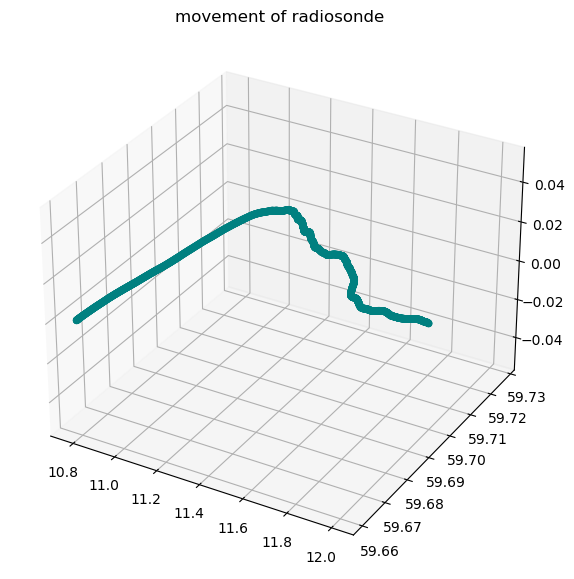

In [80]:
#find the corresponding grid points 

#points1 = []


#for i in range(np.size(df2['new_lat'])):
    
    #lat = df2['new_lat'][i]
    #lon = df2['new_long'][i]
    
    #BilinnerarPoints(filename, lat, lon)

#Removing the first row
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(df4[0]['new_long'], df4[0]['new_lat'], time[0], color = "teal")
plt.title("movement of radiosonde")

# show plot
plt.show()  


In [61]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import animatplot as amp

x = np.linspace(-2, 2, 41)
y = np.linspace(-2, 2, 41)
t = np.linspace(0, 2*np.pi, 30)

X, Y, T = np.meshgrid(x, y, t)"WSPD(knot)"

pcolormesh_data = np.sin(X*X+Y*Y-T)
line_data       = pcolormesh_data[20,:,:] # the slice where y=0

SyntaxError: invalid syntax (2162248352.py, line 10)

### Testing the Horizontal displacement function

Testing if the conversion from change in distance in meters to new longitude and latitude is correct

In [87]:
import geopy.distance
N = np.size(d_test[0]["new_lat"])
diff = []
height = []
for i in range(1, N):
        coords_2 = (d_test[0]["new_lat"][i], d_test[0]["new_long"][i])
        coords_1 = (d_test[0]["new_lat"][i-1], d_test[0]["new_long"][i-1])
        diff.append(geopy.distance.geodesic(coords_2, coords_1).m-d_test[1][i-1])
        height.append(d_test[0]['height(m)'][i])
        
print(N)

plt.plot(diff, height)
plt.show()
plt.plot(d_test[1], height)

NameError: name 'd_test' is not defined

The error could be from the assumption that there is no krumning where the distance is meassured. The distance meassured bu the function is therefore a bit smaller. However, the distance meassured 

#### Uploading a datafile with new radiosonde data to test the horizontal displacement function

In [97]:
filename = 'aas_20211231-20220131.nc'
variables_wind =["longitude", 'latitude', 'time', "time_from_launch", "wind_speed", "wind_from_direction", "geopotential_height"]
with Dataset(filename) as ncfile:
    wind_dir=ncfile[variables_wind[5]][:]
    wind_speed=ncfile[variables_wind[4]][:]
    time=ncfile[variables_wind[3]][:]
    longitude=ncfile[variables_wind[0]][:]
    latitude=ncfile[variables_wind[1]][:]
    height = ncfile[variables_wind[6]][:]
    #time_from_launch = ncfile[variables_wind[3]][:]
    
    print(ncfile)
    print(time)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    date_created: 2022-02-01T02:55:46Z
    title: Radiosonde station time series data
    Conventions: CF-1.6
    comment: Radiosonde data produced and collected by the Norwegian Meterological Institute.
    institution: Norwegian Meterological Institute
    licence: Freely distributed. Must credit the source of data, e.g. "Data from the Norwegian Meteorological Institute", "Based on data from the Norwegian Meteorological Institute". Data and products are licensed under Norwegian license for public data (NLOD) and Creative Commons Attribution 3.0 Norway. See http://met.no/English/Data_Policy_and_Data_Services.
    source: radiosonde
    station_name: aas
    wmo_block_and_station_number: 01463
    station_latitude_degrees_north: 0.5966096000000001
    station_longitude_degrees_east: 0.10781640000000002
    station_altitude_meter: 95.0
    summary: 
    featureType: 
    dimensions(sizes): time(1), tim

      longitude
0      10.78164
1      10.78164
2      10.78163
3      10.78163
4      10.78176
...         ...
2521   13.11143
2522   13.11355
2523   13.11570
2524   13.11795
2525   13.12024

[2526 rows x 1 columns]
[   0    2    4 ... 5046 5048 5050]
      WSPD(knot)  DRCT(deg)     height(m)
0       2.900000      186.0     95.099998
1            NaN        NaN           NaN
2       4.200000      186.0    108.300003
3       4.800000      186.0    119.900002
4       5.500000      186.0    131.399994
...          ...        ...           ...
2521   62.099998      273.0  25950.900391
2522   62.200001      273.0  25962.300781
2523   62.400002      273.0  25973.699219
2524   62.500000      273.0  25985.000000
2525   62.500000      273.0  25994.800781

[2526 rows x 3 columns]


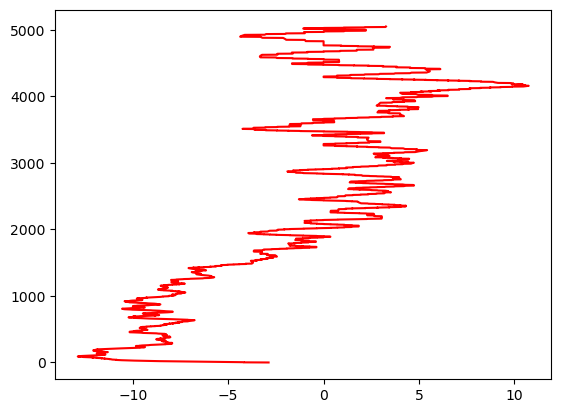

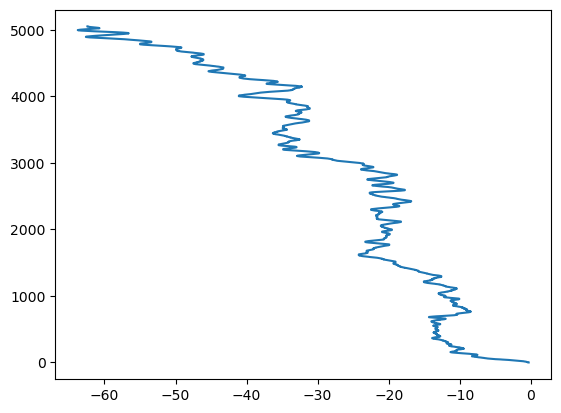

In [98]:

test_data = pd.DataFrame(wind_speed.T, columns=['WSPD(knot)'])
#"hPa", "height(m)", "Temp(C)", "DWPT", "Relh", "MIXR", 
latitude = pd.DataFrame(latitude.T, columns=['latitude'])
latitude["latitude"] = latitude["latitude"].fillna(latitude["latitude"][0])
longitude = pd.DataFrame(longitude.T, columns=['longitude'])
longitude["longitude"] = longitude["longitude"].fillna(longitude["longitude"][0])
print(longitude)
print(time)
test_data["DRCT(deg)"] = wind_dir.T
test_data["height(m)"] = height.T
print(test_data)
plt.plot(df4[0]['x_wind'], time, 'r-')
plt.show()
plt.plot(df4[0]['y_wind'], time)
#diff = []
#N = np.size(d_test[0]["new_lat"])
#for i in range(1,N):
    
    #diff.append(d_test[0]["new_lat"][i]-latitude["latitude"][i])
    #d_test[0]["new_long"][i]-longitude.T[i]
    



0       59.661000
1       59.661065
2       59.661141
3       59.661223
4       59.661316
          ...    
2521    59.732516
2522    59.732457
2523    59.732397
2524    59.732338
2525    59.732278
Name: new_lat, Length: 2526, dtype: float64
      latitude
0     59.66096
1     59.66096
2     59.66109
3     59.66117
4     59.66132
...        ...
2521  59.73131
2522  59.73125
2523  59.73119
2524  59.73112
2525  59.73103

[2526 rows x 1 columns]


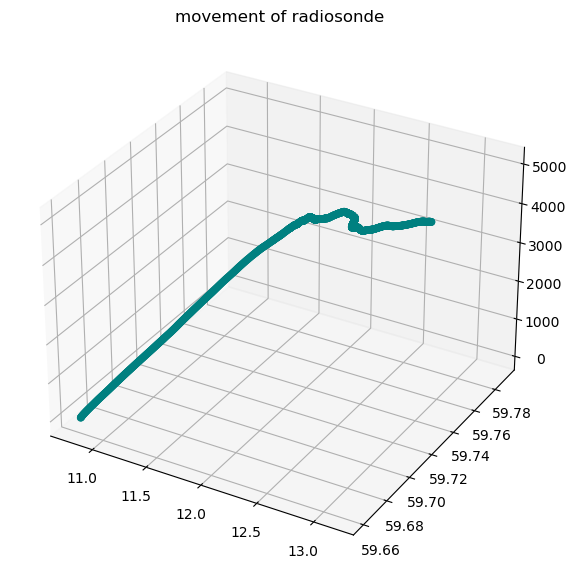

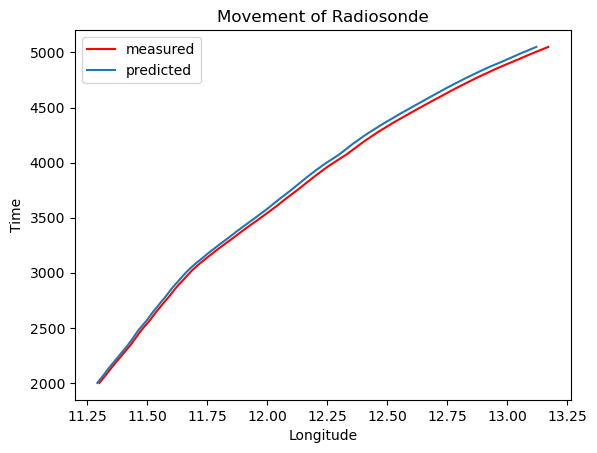

In [102]:
#df4 =df4.tail(-1) 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(df4[0]['new_long'], df4[0]['new_lat'], time, color = "teal")
plt.title("movement of radiosonde")
print(df4[0]['new_lat'])
print(latitude)
# show plot
plt.show() 

plt.plot(df4[0]['new_long'][1000:], time[1000:], 'r-')
plt.plot(longitude['longitude'][1000:], time[1000:])
plt.legend(["measured", "predicted"])
plt.xlabel("Longitude")
plt.ylabel("Time")
plt.title("Movement of Radiosonde")
plt.show()

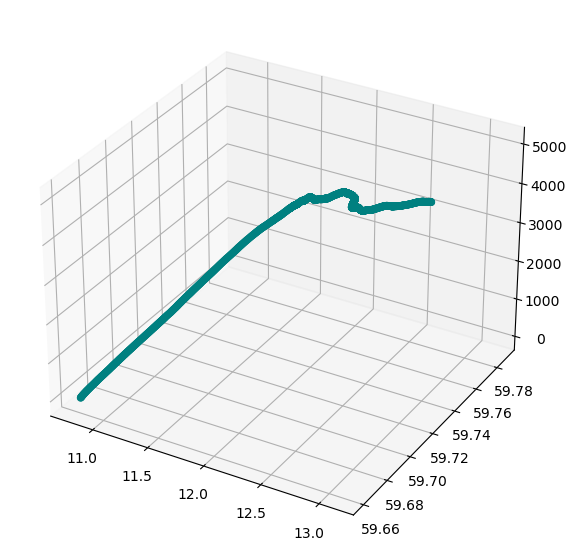

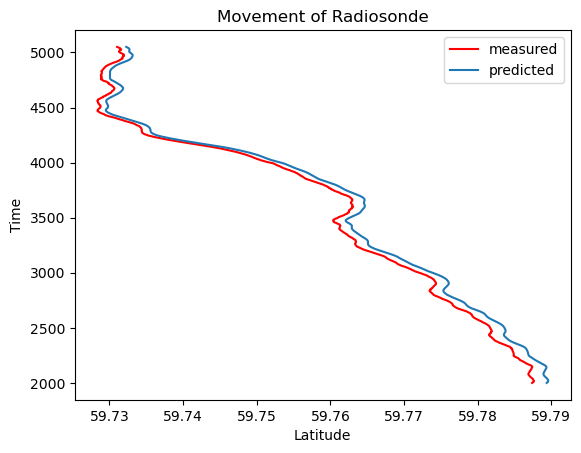

In [103]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(longitude['longitude'], latitude['latitude'], time, color = "teal")
#plt.title("movement of radiosonde")
#print(longitude['longitude'][:])
# show plot
plt.show()
line1 = plt.plot(latitude['latitude'][1000:], time[1000:], 'r-')
line2 = plt.plot(df4[0]['new_lat'][1000:], time[1000:])
plt.legend(["measured", "predicted"])
plt.xlabel("Latitude")
plt.ylabel("Time")
plt.title("Movement of Radiosonde")
plt.show()

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([8982898.20967533, 8986461.79546327, 8990025.37960922,
        8993588.96221513, 8997152.54159561, 9000716.11547631,
        9004279.6839796 , 9007843.24783727, 9011406.80718189,
        9014970.36160806, 9018533.91004997, 9014959.09546912,
        9011384.29637186, 9007809.50498739, 9004234.724259  ,
        9000659.94997091, 8997085.18089028, 8993510.41696506,
        8989935.6587398 , 8986360.90795228, 8982786.16455049]),
 <matplotlib.lines.Line2D at 0x7ff6cecc7a00>)

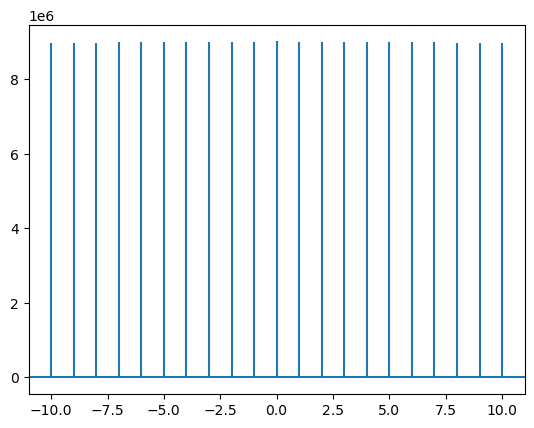

In [145]:
plt.xcorr(latitude['latitude'][:], d_test[0]['new_lat'], normed = False)


#### Making an animation

In [297]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation


# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='a red circle following a blue sine wave')
writer = FFMpegWriter(fps=15, metadata=metadata)

#Removing the first row
df3 =df2.tail(-1)
df5 =test_data.tail(-1)
n = np.size(df3['height(m)'])
# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax = plt.axes(projection ="3d")
 
# Creating plot
#ax.scatter3D(df3['new_long'], df3['new_lat'], df3['height(m)'], color = "teal")
#plt.title("movement of radiosonde")
ax.set_ylim(0,58.4)
ax.set_xlim(5.5,5.7)
ax.set_zlim(0,25000)
ax.set(facecolor="pink")
fig.set(facecolor='red')
# show plot
plt.show()  

# plot the sine wave line

red_circle, = ax.plot3D([], [], [], 'o', color = 'teal', markersize = 5)
red_circle2, = ax.plot3D([], [], [], 'o', color = 'red', markersize = 5)

# Update the frames for the movie
with writer.saving(fig, "writer_test.mp4", 1000):
    for i in range(1,n):
        
        x0 = df3['new_long'][i]
        y0 = df3['new_lat'][i]
        z0 = df3['height(m)'][i]
        x02 = df5['new_long'][i]
        y02 = df5['new_lat'][i]
        z02 = df5['height(m)'][i]
        red_circle.set_data_3d(x0, y0, z0)
        red_circle2.set_data_3d(x02, y02, z02)
        writer.grab_frame()

<IPython.core.display.Javascript object>

KeyError: 1